# ZH Monitoring overview

## Aim:
Get an overview of the statistikZH covid19monitoring dataset (https://github.com/statistikZH/covid19monitoring)


### Ideas:
- Compare trends over a week (Mo-So) - is there a change in behaviour of people over the week?
    - Hypotheses:
        - Shopping behaviours should change, including potential shifts of main shopping days
        - Larger effects around start of shutdown, weeks since then should find a new behaviour
        - Mobility: Weekend mobility should be more heavily reduced than workday mobility

In [1]:
# visualization
import colorcet # colormaps
import plotnine as gg # a great ggplot clone
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
# General
import pandas as pd
import numpy as np
import glob
import pathlib

import calendar

In [3]:
import helpers.library as lib

In [4]:
class C:
    """
    Helper class to keep input configuration.
    """
    fol_zhmonitor =  pathlib.Path('./data/monitoring/covid19monitoring/')
    fn_zhmonitor_data = fol_zhmonitor / 'covid19socialmonitoring.csv'
    fn_zhmonitor_meta = fol_zhmonitor / 'Metadata.csv'
    
    day_start = pd.to_datetime('2020-01-06')
    day_intervention_v1 = pd.to_datetime('2020-02-28') # First ban of large events
    day_intervention_v2 = pd.to_datetime('2020-03-13') # School closures
    day_intervention_v3 = pd.to_datetime('2020-03-16') # Lock down

    days_intervention = [day_intervention_v1, day_intervention_v2, day_intervention_v3]
    
    cm_discrete = colorcet.glasbey
    
class V:
    """
    Helper class to keep metadata related variables.
    """
    # Data columns:
    COL_VARIABLES = 'variable_short'
    COL_VALUE = 'value'
    COL_DATE = 'date'
    
    # Main data columns
    cols_data = [COL_VARIABLES, COL_VALUE, COL_DATE]
    
    # User data columns
    COL_MONTH = 'month'
    COL_YEAR = 'year'
    COL_WEEK = 'week'
    COL_ISWEEKDAY = 'is_weekday'
    COL_DAYOFWEEK = 'dayofweek'
    COL_HASFULLWEEK = 'fullweek' # is the measurement available for all days of that week
    COL_HASCLOSEFULLWEEK = 'almostfullweek'
    
    COL_VALUE_LOG10 = 'value_log'
    COL_VALUE_NORM = 'value_norm'
    # Meta columns:
    COL_TOPIC = 'topic'
    COL_VAR_DESC ='variable_long'
    COL_LOCATION = 'location'
    COL_UNIT = 'unit'
    COL_SOURCE = 'source'
    COL_UPDATE = 'update'
    COL_PUBLIC = 'public'
    COL_DESC_LINK = 'description'
    COL_MODIFIED = 'last_modified'
    
    

    # Categorical columns
    cols_cat = [COL_VARIABLES, COL_VAR_DESC, COL_LOCATION,
               COL_UNIT, COL_SOURCE, COL_UPDATE, COL_DESC_LINK]
    
    cols_date = [COL_MODIFIED,
                COL_DATE]
    
    COL_CANTON = 'abbreviation_canton_and_fl'
    
   



## Load and structure data

In [5]:
dat_zhmonitor = pd.read_csv(C.fn_zhmonitor_data)
dat_zhmonitor_m = pd.read_csv(C.fn_zhmonitor_meta)

In [6]:
dat_zhmonitor.head()

,date,value,topic,variable_short,variable_long,location,unit,source,update,public,description
0,2020-01-01,16.0,Sonstiges,globalstrahlung,Globalstrahlung; Tagesmittel,SMA Zürich Fluntern,W/m²,meteoschweiz,täglich,ja,https://github.com/statistikZH/covid19monitori...
1,2020-01-02,25.0,Sonstiges,globalstrahlung,Globalstrahlung; Tagesmittel,SMA Zürich Fluntern,W/m²,meteoschweiz,täglich,ja,https://github.com/statistikZH/covid19monitori...
2,2020-01-03,50.0,Sonstiges,globalstrahlung,Globalstrahlung; Tagesmittel,SMA Zürich Fluntern,W/m²,meteoschweiz,täglich,ja,https://github.com/statistikZH/covid19monitori...
3,2020-01-04,19.0,Sonstiges,globalstrahlung,Globalstrahlung; Tagesmittel,SMA Zürich Fluntern,W/m²,meteoschweiz,täglich,ja,https://github.com/statistikZH/covid19monitori...
4,2020-01-05,74.0,Sonstiges,globalstrahlung,Globalstrahlung; Tagesmittel,SMA Zürich Fluntern,W/m²,meteoschweiz,täglich,ja,https://github.com/statistikZH/covid19monitori...


In [7]:
dat_zhmonitor_m.head()

,topic,variable_short,variable_long,location,unit,source,update,public,description,last_modified
0,Sonstiges,globalstrahlung,Globalstrahlung; Tagesmittel,SMA Zürich Fluntern,W/m²,meteoschweiz,täglich,ja,https://github.com/statistikZH/covid19monitori...,2020-04-06
1,Sonstiges,luftdruck,Luftdruck auf Stationshöhe (QFE); Tagesmittel,SMA Zürich Fluntern,hPa,meteoschweiz,täglich,ja,https://github.com/statistikZH/covid19monitori...,2020-04-06
2,Sonstiges,sonnenschein,Sonnenscheindauer; Tagessumme,SMA Zürich Fluntern,min,meteoschweiz,täglich,ja,https://github.com/statistikZH/covid19monitori...,2020-04-06
3,Sonstiges,temp_mittel,Lufttemperatur 2 m über Boden; Tagesmittel,SMA Zürich Fluntern,°C,meteoschweiz,täglich,ja,https://github.com/statistikZH/covid19monitori...,2020-04-06
4,Sonstiges,temp_min,Lufttemperatur 2 m über Boden; Tagesminimum,SMA Zürich Fluntern,°C,meteoschweiz,täglich,ja,https://github.com/statistikZH/covid19monitori...,2020-04-06


In [8]:
# Delete redundant variables in data
dat_zhmonitor = dat_zhmonitor[V.cols_data]

In [9]:
# Convert date
def apply_to_cols(df, cols, fkt, inplace = True):
    if not inplace:
        df = df.copy()
    for c in set(cols).intersection(df.columns):
        df.loc[:, c] = fkt(df.loc[:, c])
    return df



In [10]:
# Convert variables to datetime and categorical
for d in [dat_zhmonitor, dat_zhmonitor_m]:
    apply_to_cols(d, V.cols_date, pd.to_datetime)
    apply_to_cols(d, V.cols_cat, pd.Categorical)

In [11]:
dat_zhmonitor

,variable_short,value,date
0,globalstrahlung,16.0,2020-01-01
1,globalstrahlung,25.0,2020-01-02
2,globalstrahlung,50.0,2020-01-03
3,globalstrahlung,19.0,2020-01-04
4,globalstrahlung,74.0,2020-01-05
...,...,...,...
3342,oev_freq_hb,1644.0,2020-03-30
3343,oev_freq_hb,1642.0,2020-03-31
3344,oev_freq_hb,1639.0,2020-04-01
3345,oev_freq_hb,1639.0,2020-04-04


In [12]:
# Convert date into week, year and weekday

dat_zhmonitor[V.COL_DAYOFWEEK] = pd.Categorical.from_codes(dat_zhmonitor[V.COL_DATE].dt.dayofweek,
                                             categories=list(calendar.day_abbr), ordered=True)

In [13]:
dat_zhmonitor[V.COL_MONTH] = pd.Categorical.from_codes(dat_zhmonitor[V.COL_DATE].dt.month,
                                          categories=list(calendar.month_abbr))

In [14]:
dat_zhmonitor[V.COL_WEEK] = pd.Categorical.from_codes(dat_zhmonitor[V.COL_DATE].dt.week,
                                          categories=[str(i) for i in range(53)])

In [15]:
dat_zhmonitor[V.COL_YEAR] = pd.Categorical(dat_zhmonitor[V.COL_DATE].dt.year.astype(str))

In [16]:
# Convert date into week, year and weekday

dat_zhmonitor[V.COL_ISWEEKDAY] = dat_zhmonitor[V.COL_DATE].dt.dayofweek < 5

In [17]:
dat_zhmonitor[V.COL_HASFULLWEEK] = dat_zhmonitor.groupby([V.COL_YEAR, V.COL_WEEK, V.COL_VARIABLES])[V.COL_VALUE].transform(lambda x: np.sum(np.isfinite(x)) == 7)

In [18]:
dat_zhmonitor[V.COL_HASCLOSEFULLWEEK] = dat_zhmonitor.groupby([V.COL_YEAR, V.COL_WEEK, V.COL_VARIABLES])[V.COL_VALUE].transform(lambda x: np.sum(np.isfinite(x)) >=5)

In [19]:
dat_zhmonitor[V.COL_DAYOFWEEK].tail()

3342    Mon
3343    Tue
3344    Wed
3345    Sat
3346    Sun
Name: dayofweek, dtype: category
Categories (7, object): [Mon < Tue < Wed < Thu < Fri < Sat < Sun]

In [20]:
dat_zhmonitor[V.COL_ISWEEKDAY].tail()

3342     True
3343     True
3344     True
3345    False
3346    False
Name: is_weekday, dtype: bool

## Plot all the data to better understand what's there

In [21]:
dat_zhmonitor.query(f'{V.COL_VARIABLES} == "tages_distanz_median"')

,variable_short,value,date,dayofweek,month,week,year,is_weekday,fullweek,almostfullweek
768,tages_distanz_median,13.745760,2020-02-16,Sun,Feb,7,2020,False,False,True
769,tages_distanz_median,13.127870,2020-02-16,Sun,Feb,7,2020,False,False,True
770,tages_distanz_median,11.615768,2020-02-16,Sun,Feb,7,2020,False,False,True
771,tages_distanz_median,15.409376,2020-02-16,Sun,Feb,7,2020,False,False,True
772,tages_distanz_median,13.127870,2020-02-16,Sun,Feb,7,2020,False,False,True
...,...,...,...,...,...,...,...,...,...,...
1392,tages_distanz_median,6.429393,2020-04-04,Sat,Apr,14,2020,False,False,True
1393,tages_distanz_median,6.790338,2020-04-04,Sat,Apr,14,2020,False,False,True
1394,tages_distanz_median,5.110898,2020-04-04,Sat,Apr,14,2020,False,False,True
1395,tages_distanz_median,9.253534,2020-04-04,Sat,Apr,14,2020,False,False,True


/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_vline : Removed 297 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


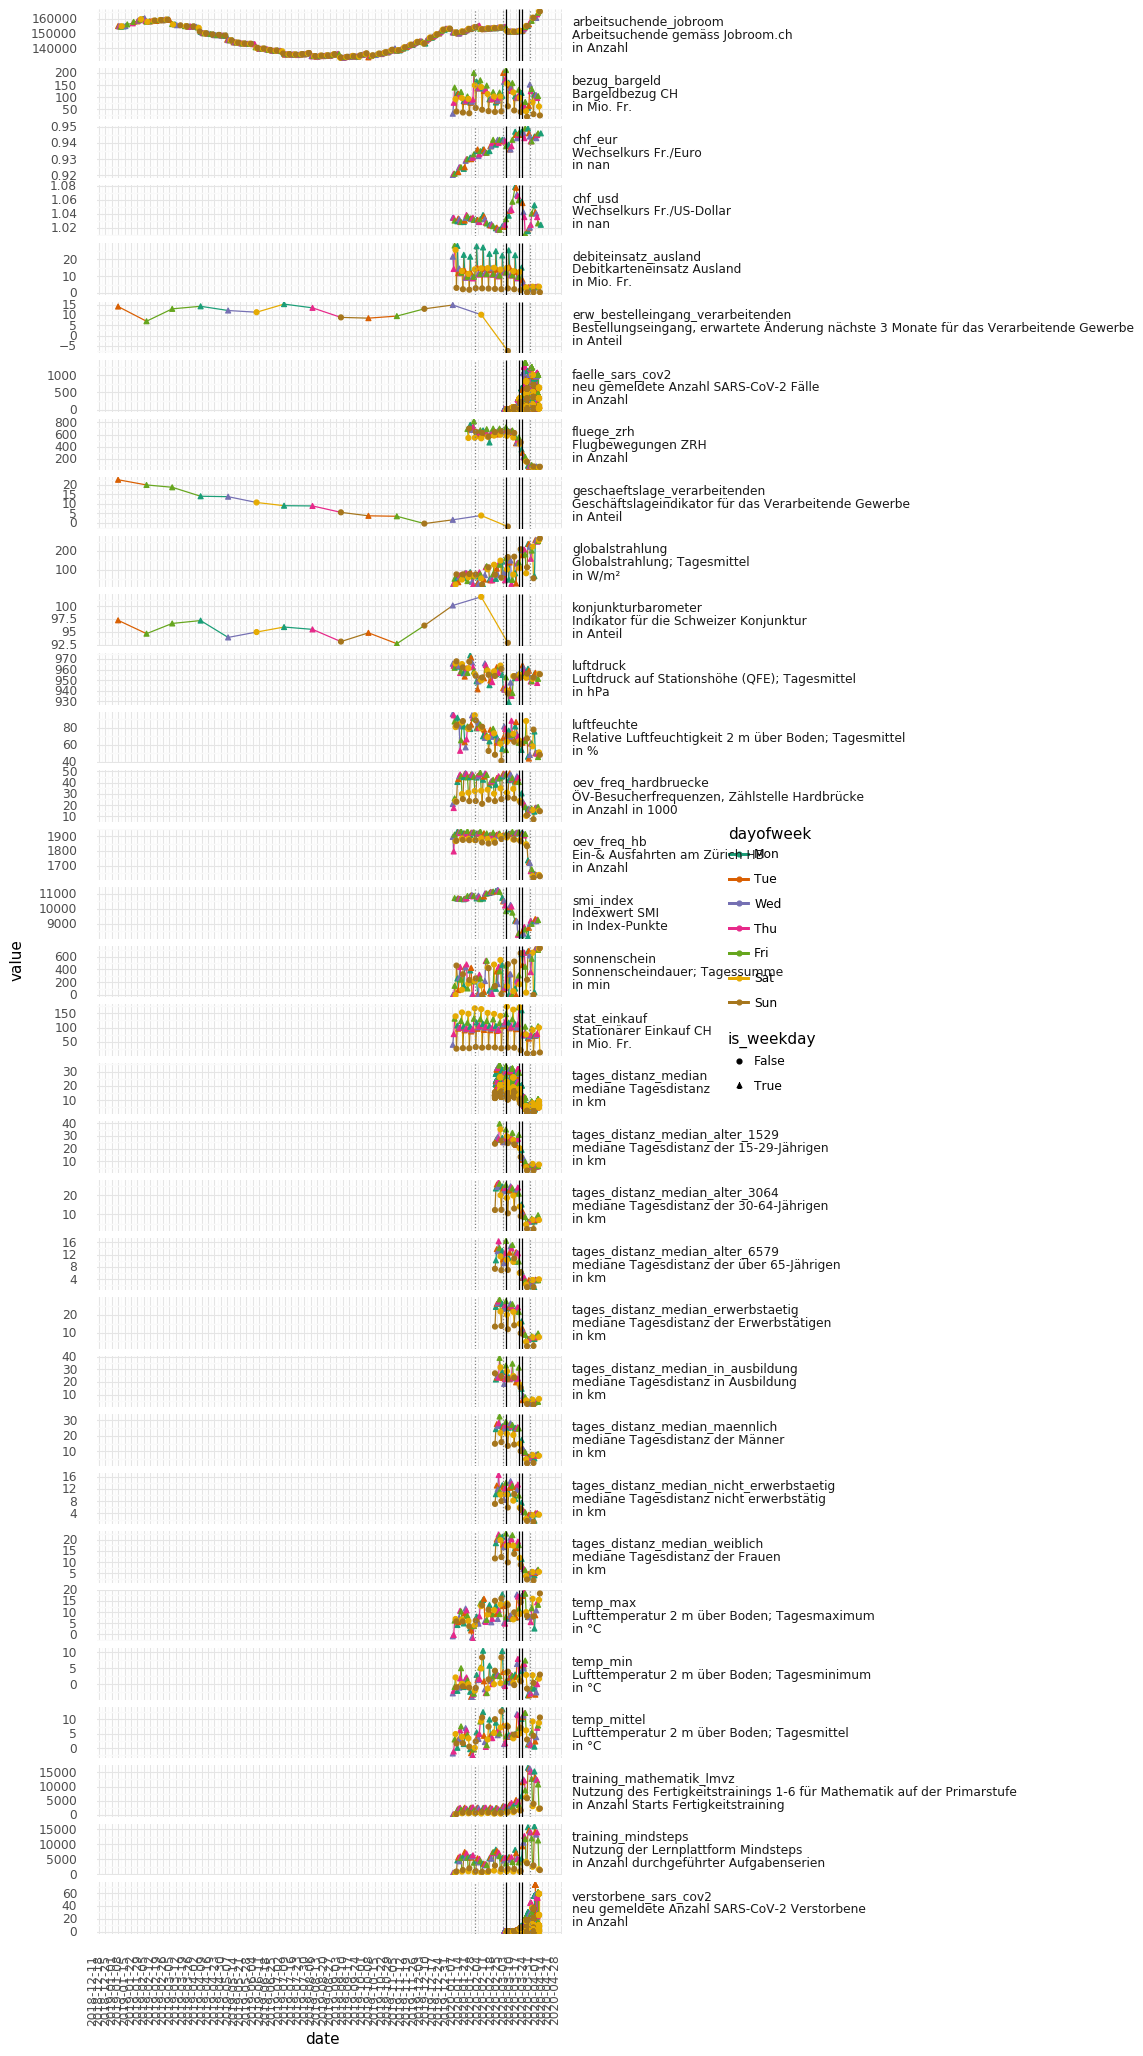

<ggplot: (8790809582607)>

In [22]:
p = (dat_zhmonitor 
 .merge(dat_zhmonitor_m[[V.COL_VARIABLES, V.COL_VAR_DESC, V.COL_UNIT]])
 .assign(**{'label': lambda x: x.apply(lambda r: f'{r[V.COL_VARIABLES]}\n{r[V.COL_VAR_DESC]}\nin {r[V.COL_UNIT]}',
    axis=1)})
 >>    
    gg.ggplot(gg.aes(x=V.COL_DATE, y=V.COL_VALUE, color=V.COL_DAYOFWEEK, shape=V.COL_ISWEEKDAY))
        + gg.facet_grid(f'label~.', scales='free'
                       )
        + gg.geom_line(gg.aes(group=V.COL_VARIABLES))
        + gg.geom_point(size=1.5)
     + gg.scale_color_cmap_d('Dark2')   
     #+ gg.scale_color_brewer(type='qual',palette=2)
     + gg.geom_vline(xintercept=[pd.to_datetime(f'2020-{m}-25') for m in range(1,13)],
                    color='gray', linetype=':')
     + gg.geom_vline(xintercept=C.days_intervention)
        + gg.theme_minimal()
        + gg.theme(axis_text_x = gg.element_text(angle = 90, hjust = 1),
               figure_size=(6,25),
                   strip_text_y = gg.element_text(angle = 0,ha='left'),
                   strip_margin_x=6,
                #   legend_position='left'
               )
     

)
(p
 + gg.scale_x_date(limits=[dat_zhmonitor[V.COL_DATE].min(), dat_zhmonitor[V.COL_DATE].max()],date_breaks='1 week')

)

/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 395 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_vline : Removed 297 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


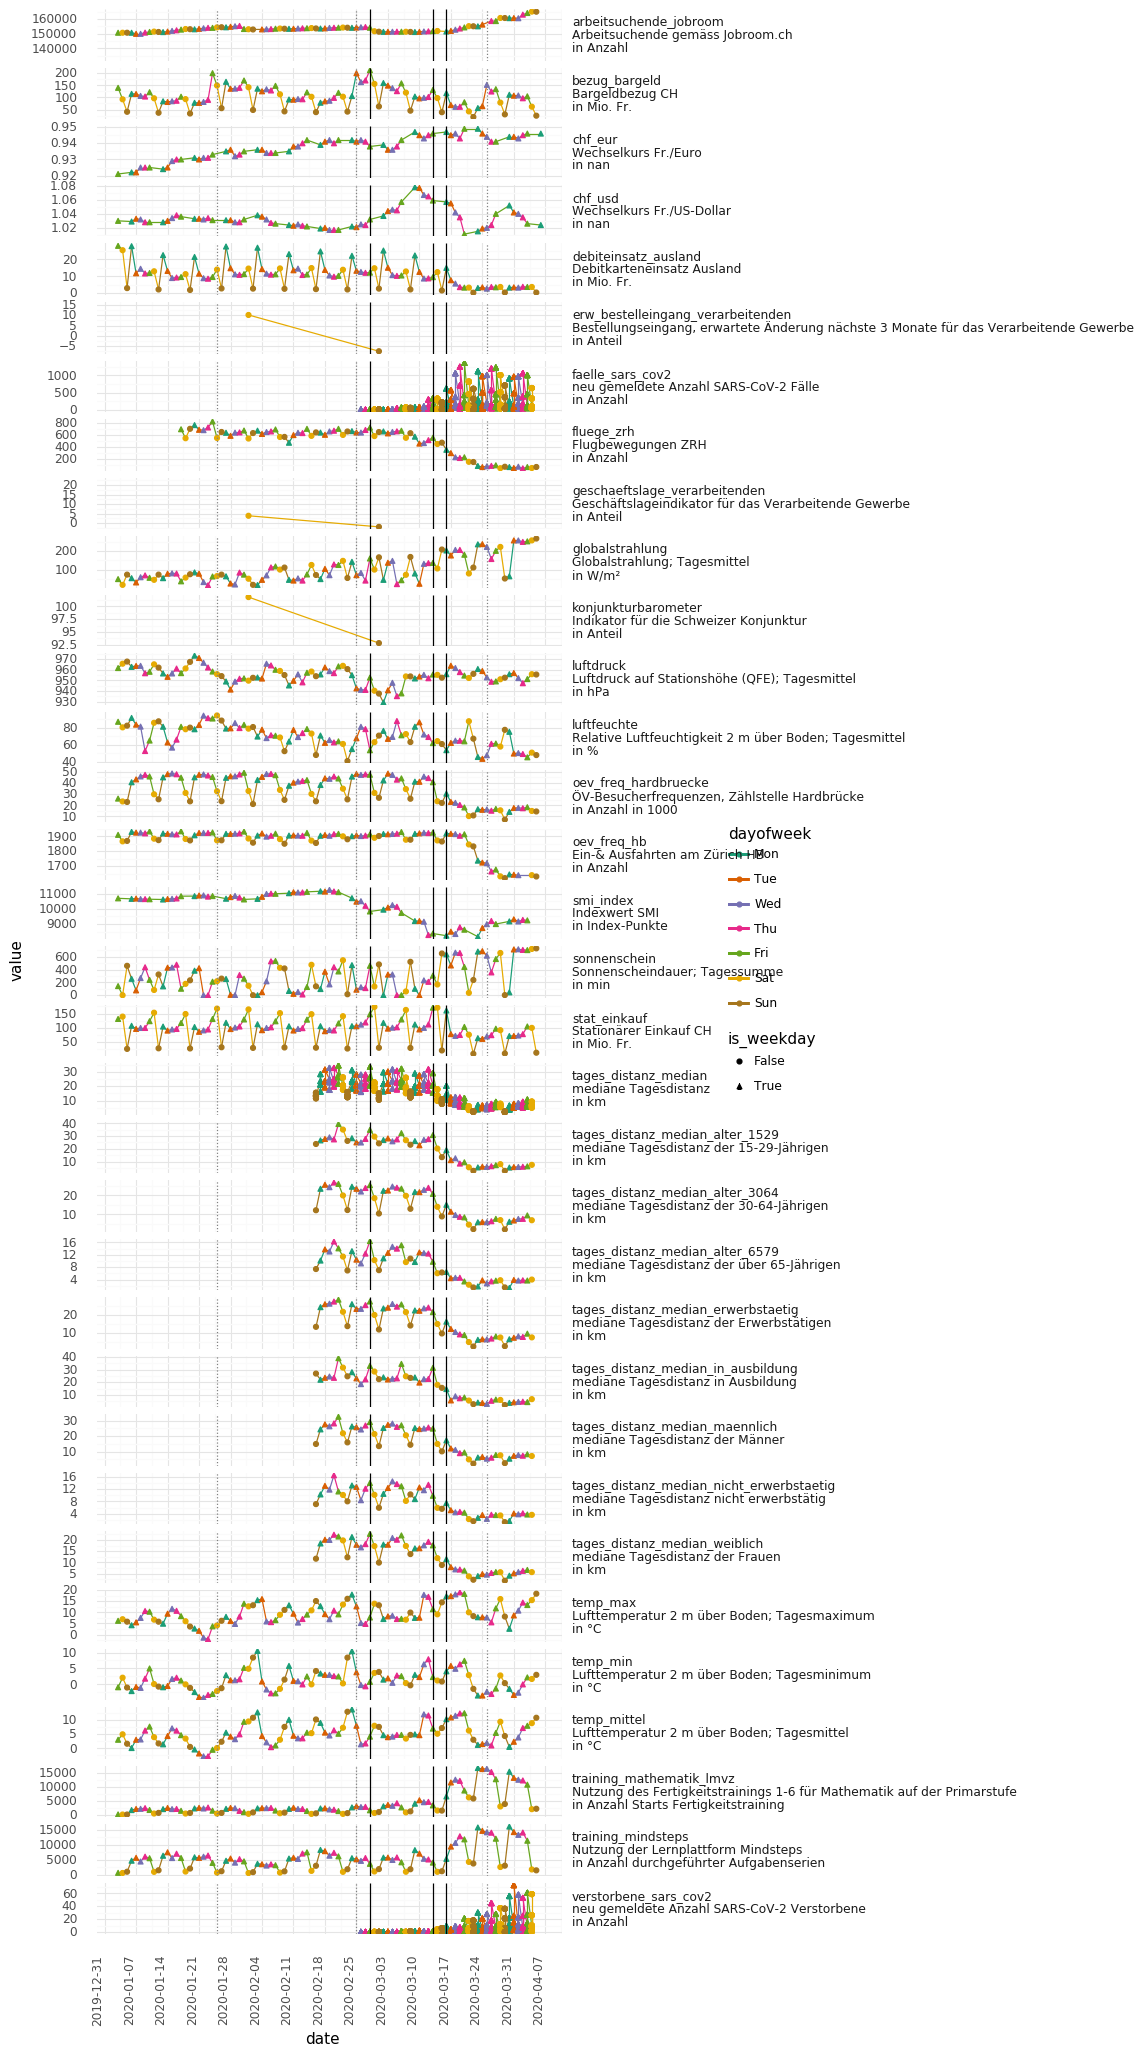

<ggplot: (-9223363246045198669)>

In [23]:
# It seems that it would be better to only focus on the data since 03.01

(p
 + gg.scale_x_date(limits=[pd.to_datetime('2020-01-03'), dat_zhmonitor[V.COL_DATE].max()],date_breaks='1 week')

)

After looking at the data, it could indeed be interesting to look at changes in behaviour over the weekdays

- Use data from 3. Januar 2020 (Schulanfang)
- Week from Monday-Sunday
- Normalize by average levels of weekdays - weekends seem often more variable/outliers
    -> TODO: Check if really true

/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 24 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 24 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 36'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)
/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_bin : Removed 24 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 36'. Pick bett

1

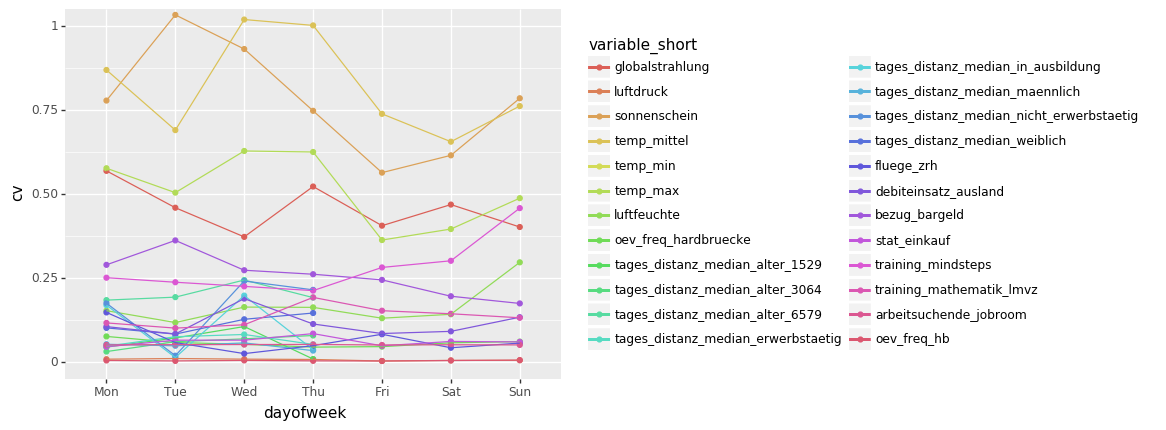

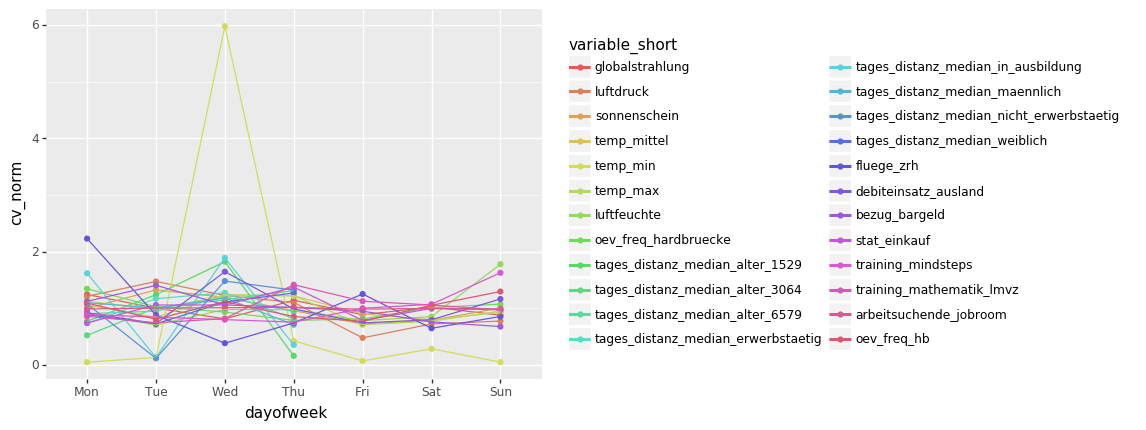

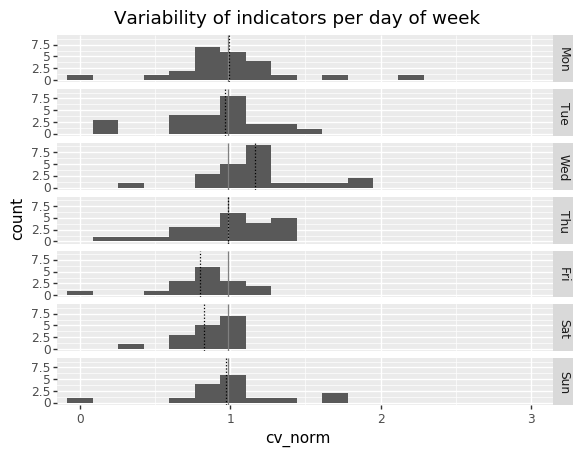

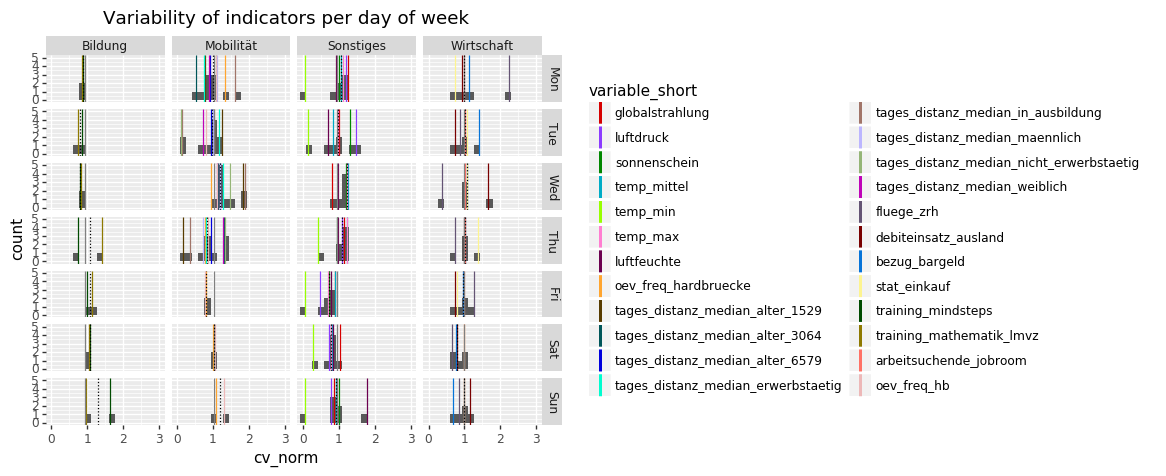

In [24]:
# Quickly check variability of weekdays vs weekends over weeks
tdat = (dat_zhmonitor
        .merge(dat_zhmonitor_m[[V.COL_VARIABLES, V.COL_TOPIC]])
 #.query(f'{V.COL_DATE} < {C.days_intervention[0]}') # doesnt work with dates yet
 .query(f'{V.COL_HASFULLWEEK} == True')
 .pipe(lambda d: d.loc[d[V.COL_DATE] < C.days_intervention[0],:])# only before intervention
 .groupby([V.COL_DAYOFWEEK, V.COL_VARIABLES, V.COL_TOPIC], observed=True)[V.COL_VALUE].describe()
 .reset_index()
 .assign(**{'cv': lambda x: x['std']/np.abs(x['mean'])})
 .assign(**{'cv_norm': lambda d: d.groupby(V.COL_VARIABLES)['cv']
                  .transform(lambda x: x/x.mean())})
 
       )




(tdat >>
 gg.ggplot(gg.aes(x=V.COL_DAYOFWEEK, y= 'cv', color=V.COL_VARIABLES))
 + gg.geom_point()
 + gg.geom_line(gg.aes(group=V.COL_VARIABLES))
 #+ gg.geom_smooth(gg.aes(group=V.COL_VARIABLES), method='lm')
 + gg.coord_cartesian(ylim=(0,1))

).draw()

(tdat >>
 gg.ggplot(gg.aes(x=V.COL_DAYOFWEEK, y= 'cv_norm', color=V.COL_VARIABLES))
 + gg.geom_point()
 + gg.geom_line(gg.aes(group=V.COL_VARIABLES))

 #+ gg.geom_smooth(gg.aes(group=V.COL_VARIABLES), method='lm')


).draw()

(tdat >>
 gg.ggplot(gg.aes(x= 'cv_norm'))
 + gg.facet_grid(f'{V.COL_DAYOFWEEK}~.')
 + gg.geom_histogram()
  + gg.geom_vline(xintercept=np.nanmedian(tdat['cv_norm']), color='grey')
 + gg.geom_vline(gg.aes(xintercept='cv_norm'),
                 data=(tdat
                       .groupby(V.COL_DAYOFWEEK, observed=True)['cv_norm']
                       .median().reset_index()),
                 
                 
                 linetype=':')
 #+ gg.geom_smooth(gg.aes(group=V.COL_VARIABLES), method='lm')
    + gg.coord_cartesian(xlim=(0,3))
 +  gg.ggtitle('Variability of indicators per day of week')
 
).draw()

(tdat >>
 gg.ggplot(gg.aes(x= 'cv_norm'))
 + gg.facet_grid(f'{V.COL_DAYOFWEEK}~{V.COL_TOPIC}')
 + gg.geom_histogram()
  + gg.geom_vline(gg.aes(xintercept='cv_norm', color=V.COL_VARIABLES))
  + gg.scale_color_manual(C.cm_discrete)
  + gg.geom_vline(gg.aes(xintercept='cv_norm'),
                                   data=(tdat
                       .groupby([V.COL_TOPIC], observed=True)['cv_norm']
                       .median().reset_index()),  color='grey')
 + gg.geom_vline(gg.aes(xintercept='cv_norm'),
                 data=(tdat
                       .groupby([V.COL_DAYOFWEEK, V.COL_TOPIC], observed=True)['cv_norm']
                       .median().reset_index()),                 
                 linetype=':')
    + gg.coord_cartesian(xlim=(0,3))
 +  gg.ggtitle('Variability of indicators per day of week')
 
).draw()
1

-> Surprisingly (to me) variabiltiy fo the readouts doesnt seem strongly weekday dependent

Still I would like to compare weekend and weekday, thus I will normalize by average weekday.

In [25]:
dat_zhmonitor = (dat_zhmonitor
 .assign(**{
     V.COL_VALUE_LOG10: lambda x: np.log10(x[V.COL_VALUE])})
 .assign(**{
         #V.COL_VALUE_NORM: 
         #lambda d: (d.groupby([V.COL_YEAR, V.COL_WEEK, V.COL_VARIABLES],group_keys=False))
         #           .apply(lambda x:
         #                      x[V.COL_VALUE_LOG10]-x.loc[x[V.COL_ISWEEKDAY] == True, V.COL_VALUE_LOG10].mean())
                   
          V.COL_VALUE_NORM: 
         lambda d: (d.groupby([V.COL_YEAR, V.COL_WEEK, V.COL_VARIABLES],group_keys=False)
                    .apply(lambda x:
                               x[V.COL_VALUE]/x[V.COL_VALUE].mean())
                   )
     
 })
)    
 
    

/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


How do the previous plot look per week?

/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 24 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/vitoz/miniconda3/envs/covid/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_vline : Removed 270 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


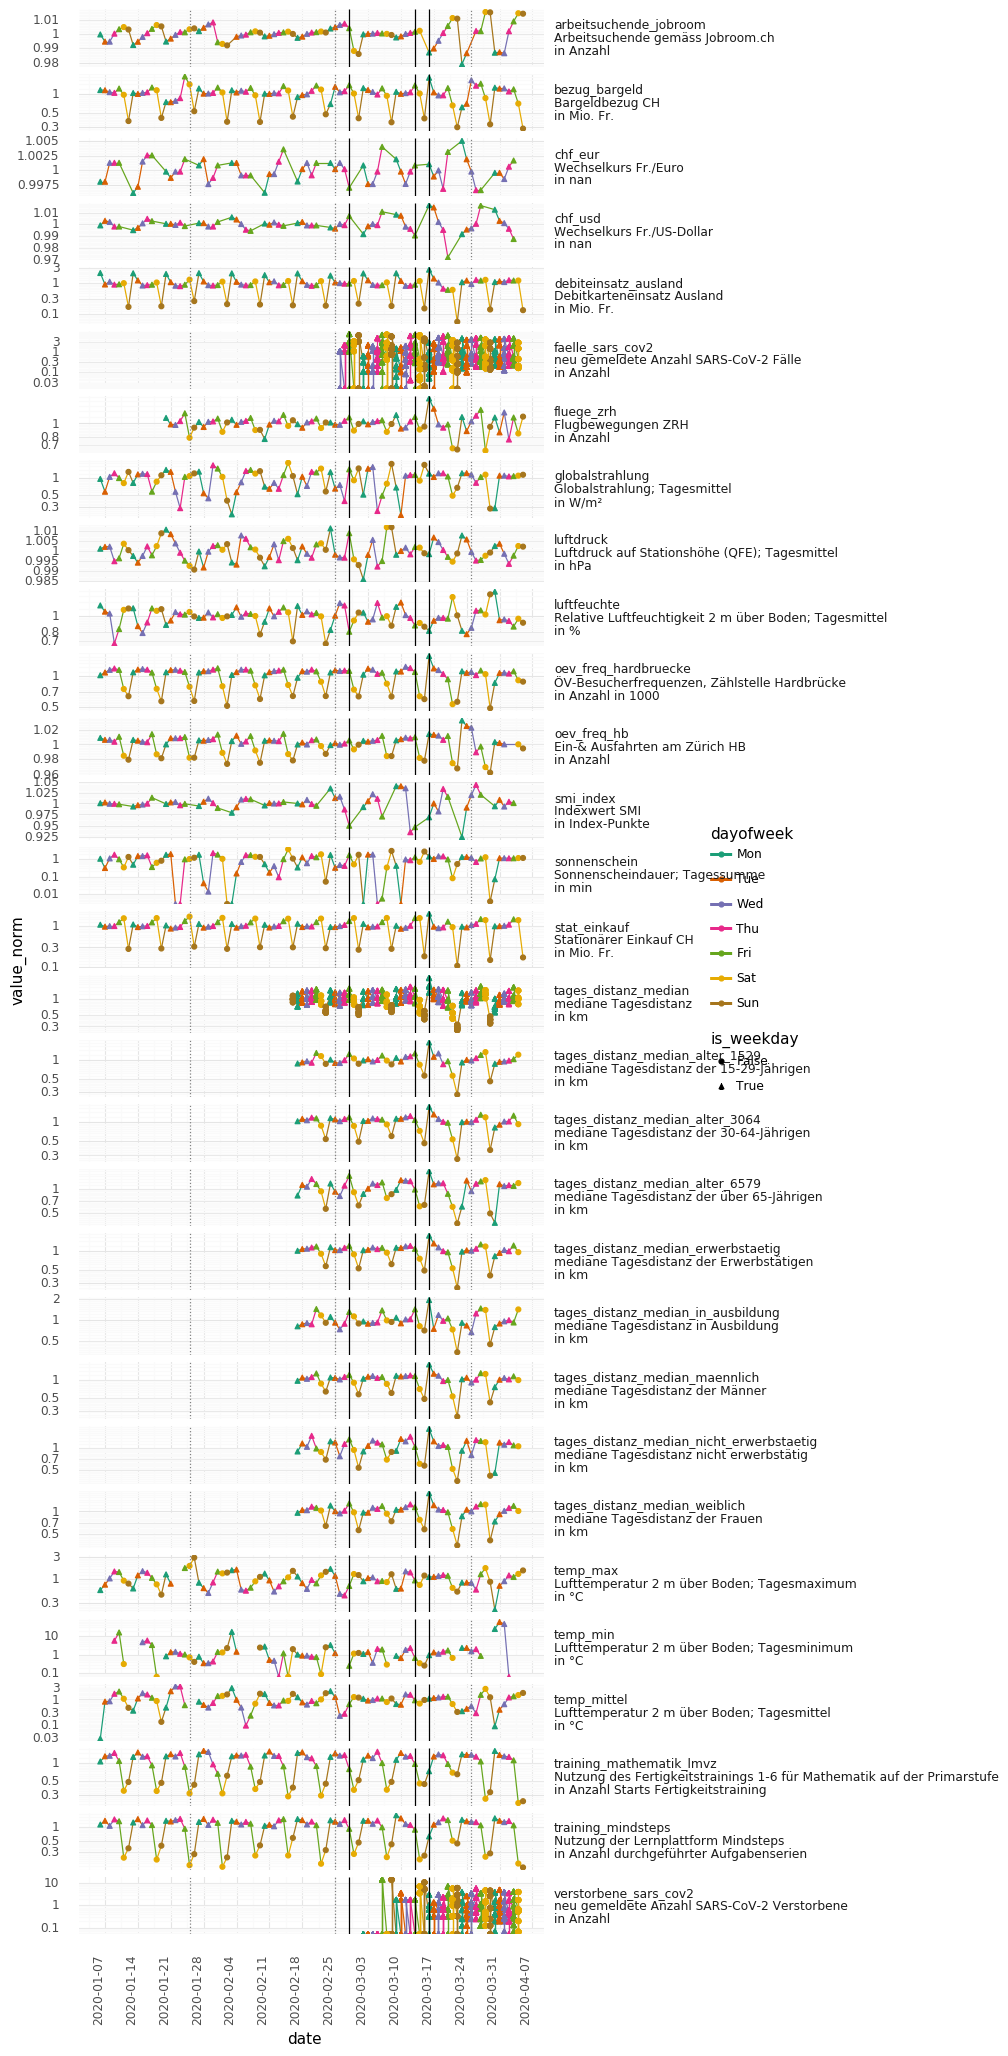

<ggplot: (8790705505505)>

In [26]:
pdat = (dat_zhmonitor 
      .query(f'{V.COL_HASCLOSEFULLWEEK} == True')
  
 .pipe(lambda d: d.loc[d[V.COL_DATE] >= C.day_start,:])# only before intervention
.pipe(lambda d: d.loc[np.isfinite(d[V.COL_VALUE_NORM]),:])# only finite
 .merge(dat_zhmonitor_m[[V.COL_VARIABLES, V.COL_VAR_DESC, V.COL_UNIT]])
 .assign(**{'label': lambda x: x.apply(lambda r: f'{r[V.COL_VARIABLES]}\n{r[V.COL_VAR_DESC]}\nin {r[V.COL_UNIT]}',
    axis=1)})
       )
p = (pdat >>    
    gg.ggplot(gg.aes(x=V.COL_DATE, y=V.COL_VALUE_NORM, color=V.COL_DAYOFWEEK, shape=V.COL_ISWEEKDAY))
        + gg.facet_grid(f'label~.', scales='free'
                       )
        + gg.geom_line(gg.aes(group=[V.COL_WEEK]))
        + gg.geom_point(size=1.5)
     + gg.scale_color_cmap_d('Dark2')   
     #+ gg.scale_color_brewer(type='qual',palette=2)
     + gg.geom_vline(xintercept=[pd.to_datetime(f'2020-{m}-25') for m in range(1,13)],
                    color='gray', linetype=':')
     + gg.geom_vline(xintercept=C.days_intervention)
        + gg.theme_minimal()
        + gg.theme(axis_text_x = gg.element_text(angle = 90, hjust = 1),
               figure_size=(6,25),
                   strip_text_y = gg.element_text(angle = 0,ha='left'),
                   strip_margin_x=6,
                #   legend_position='left'
               )
     
    + gg.scale_x_date(limits=[pdat[V.COL_DATE].min(), pdat[V.COL_DATE].max()],date_breaks='1 week')
    + gg.scale_y_log10()
)
p
 



My conda environment

In [27]:
import sys
!conda env export -p {sys.prefix}

name: null
channels:
  - r
  - bioconda
  - pyviz
  - conda-forge
  - defaults
dependencies:
  - _libgcc_mutex=0.1=main
  - _r-mutex=1.0.0=mro_2
  - attrs=19.3.0=py_0
  - backcall=0.1.0=py_0
  - binutils_impl_linux-64=2.31.1=h6176602_1
  - binutils_linux-64=2.31.1=h6176602_8
  - blas=2.14=openblas
  - bleach=1.4.2=py36_0
  - boost-cpp=1.70.0=ha2d47e9_1
  - branca=0.4.0=py_0
  - bzip2=1.0.8=h516909a_2
  - ca-certificates=2019.11.28=hecc5488_0
  - cairo=1.14.12=h8948797_3
  - certifi=2019.11.28=py36h9f0ad1d_1
  - cffi=1.14.0=py36hd463f26_0
  - cfitsio=3.470=hb60a0a2_2
  - chardet=3.0.4=py36h9f0ad1d_1006
  - click=7.1.1=pyh8c360ce_0
  - click-plugins=1.1.1=py_0
  - cligj=0.5.0=py_0
  - colorcet=2.0.2=py_0
  - cryptography=2.8=py36h45558ae_2
  - curl=7.65.3=hbc83047_0
  - cycler=0.10.0=py_2
  - dbus=1.13.12=h746ee38_0
  - decorator=4.4.2=py_0
  - defusedxml=0.6.0=py_0
  - descartes=1.1.0=py_4
  - entrypoints=0.3=py36h9f0ad1d_1001
  - expat=2.2.9=he1b5a44_2
  - fiona=1.8.13=py36h900e953_0
 